# Disease prediction from microbiome structure using ML

In [1]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [151]:
# # Download abundance data from GMrepo

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/superkingdom2descendents.txt.gz", "superkingdom2descendents.txt.gz")
# print("taxonomy table download finished)

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/samples_loaded.txt.gz", "samples_loaded.txt.gz")
# print("sample table download finished)

# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/sample_to_run_info.txt.gz", "sample_to_run_info.txt.gz")
# print("sample run download finished)
      
# urllib.request.urlretrieve("https://gmrepo.humangut.info/Downloads/SQLDumps/species_abundance.txt.gz", "species_abundance.txt.gz")
# print("abundance table download finished)

In [520]:
#import data

abundance_raw = pd.read_table("species_abundance.txt")
taxonomy_table = pd.read_table("superkingdom2descendents.txt")
sample_table = pd.read_table("samples_loaded.txt")
run_table = pd.read_table("sample_to_run_info.txt", dtype = 'str')

In [521]:
# using only genus for this project

abundance_genus  = abundance_raw[abundance_raw['taxon_rank_level'].str.contains('genus', case=False)]

In [522]:
# reformat: rownames are samples and colnames are taxa

pivoted_df = abundance_genus.pivot_table(index='loaded_uid', columns='ncbi_taxon_id', values='relative_abundance', fill_value=0)

In [523]:
# rename colnames with actual genus names

# Replace blanks with underscores in the scientific_name column
taxonomy_table['scientific_name'] = taxonomy_table['scientific_name'].str.replace(' ', '_')

# Create a mapping between ncbi_taxon_id and scientific_name
mapping = dict(zip(taxonomy_table['ncbi_taxon_id'], taxonomy_table['scientific_name']))

# Rename columns in pivoted_df based on the mapping
pivoted_df.rename(columns=mapping, inplace=True)

In [524]:
pivoted_df #taxonomy table is incomplete... must complete later with newer ncbi tax tables

ncbi_taxon_id,-1,Azorhizobium,Cellvibrio,Dictyoglomus,Methylophilus,Pelobacter,Phenylobacterium,Shewanella,Myxococcus,Stigmatella,...,2211641,2212691,2212731,2282523,2282740,2282741,2282742,2304691,2304692,2529408
loaded_uid,,,,,,,,,,,,,,,,,,,,,
1,0.29633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.36680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.13739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3.32762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52855,9.70667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52856,1.01729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52857,3.61897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [525]:
#merge metadata into a single df

metadata_df = pd.merge(run_table, sample_table, left_on='run_id', right_on='accession_id')

In [526]:
metadata_df

,checking,project_id,our_project_id,sample_name,original_sample_description,curated_sample_description,run_id,sample_id,second_sample_id,experiment_type,...,Antibiotics.Dose,Days.Without.Antibiotics.Use,uid,accession_id,data_type,tool_used,results_version,last_updated,QCStatus,QCMessage
0,1,PRJDB4360,NaN,Japanese001,Healthy Japanese gut microbiota,NaN,DRR048993,NaN,SAMD00042843,Amplicon,...,NaN,NaN,6339,DRR048993,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
1,1,PRJDB4360,NaN,Japanese002,Healthy Japanese gut microbiota,NaN,DRR048994,NaN,SAMD00042844,Amplicon,...,NaN,NaN,6340,DRR048994,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
2,1,PRJDB4360,NaN,Japanese003,Healthy Japanese gut microbiota,NaN,DRR048995,NaN,SAMD00042845,Amplicon,...,NaN,NaN,6341,DRR048995,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
3,1,PRJDB4360,NaN,Japanese004,Healthy Japanese gut microbiota,NaN,DRR048996,NaN,SAMD00042846,Amplicon,...,NaN,NaN,6342,DRR048996,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
4,1,PRJDB4360,NaN,Japanese005,Healthy Japanese gut microbiota,NaN,DRR048997,NaN,SAMD00042847,Amplicon,...,NaN,NaN,6343,DRR048997,amplicon,Mapseq,1.0,2019-01-01 00:00:00,0,less than 20k reads after trimming
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53303,1,PRJNA215106,NaN,F34_CY,Functional metagenomic selections were perform...,NaN,SRR961853,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6008,SRR961853,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53304,1,PRJNA215106,NaN,F34_PE,Functional metagenomic selections were perform...,NaN,SRR961854,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6060,SRR961854,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53305,1,PRJNA215106,NaN,F34_TE,Functional metagenomic selections were perform...,NaN,SRR961855,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,7342,SRR961855,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53306,1,PRJNA215106,NaN,F34_TR,Functional metagenomic selections were perform...,NaN,SRR961856,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6054,SRR961856,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN


### Data cleaning

In [527]:
## metadata cleaning

# 1) Remove rows where QCStatus is equal to 0 (didn't pass quality filter)
metadata_df = metadata_df[metadata_df['QCStatus'] != 0]

# 2) Remove rows with a phenotype value_count < 100 (too few samples for robust ML)
phenotype_counts = metadata_df['phenotype'].value_counts()
phenotypes_to_keep = phenotype_counts[phenotype_counts >= 100].index
metadata_df = metadata_df[metadata_df['phenotype'].isin(phenotypes_to_keep)]

# 3) rename healthy, health and Normal to Healthy; rename IBD synonyms
metadata_df['phenotype'] = metadata_df['phenotype'].replace(['healthy', 'Health', 'Normal'], 'Healthy')
metadata_df['phenotype'] = metadata_df['phenotype'].replace(['IBD', 'Inflamatory Bowel Diseases'], 'Inflamatory Bowel Disease')

# 4) Find and remove duplicated rows (excluding the 'phenotype' column)

#duplicated uids to filter from abundance table
duplicated_uids = metadata_df[metadata_df.duplicated(subset=non_phenotype_columns, keep=False)]['uid']
duplicated_uids = duplicated_uids.unique()

non_phenotype_columns = metadata_df.columns.difference(['phenotype'])
duplicated_rows = metadata_df.duplicated(subset=non_phenotype_columns, keep=False)
metadata_df = metadata_df[~duplicated_rows]

In [530]:
## abundance cleaning

# 1) exclude data uids from the abundance table that are not in the metadata table
uids_to_keep = metadata_df["uid"]
pivoted_df_filtered = pivoted_df.loc[uids_to_keep]

In [531]:
# check

if len(metadata_df) == len(pivoted_df_filtered) and (metadata_df["uid"] == pivoted_df_filtered.index).all():
    print("\nMetadata and abundance tables are the same length and have the same content in the same order 👍\n")
else:
    print("\ngrab a coffee\n")


Metadata and abundance tables are the same length and have the same content in the same order 👍



In [532]:
# separate healthy from everything else through uids

# 1) Filter rows with phenotype "Healthy"
healthy_uids = metadata_df.loc[metadata_df["phenotype"] == "Healthy", "uid"]
pivoted_df_Healthy = pivoted_df_filtered.loc[healthy_uids]
pivoted_df_Healthy = pivoted_df_Healthy.iloc[:, 1:] #remove unknown column

# 2) Create another DataFrame with non-Healthy rows
pivoted_df_non_healthy = pivoted_df_filtered.drop(healthy_uids, errors='ignore')
pivoted_df_non_healthy = pivoted_df_non_healthy.iloc[:, 1:] #remove unknown column

In [535]:
# cross check

if len(pivoted_df_Healthy) + len(pivoted_df_non_healthy) == len(metadata_df):
    print("\nSeparated abundance dfs are correct 👍\n")
else:
    print("\ngrab a coffee\n")


Separated abundance dfs are correct 👍



In [536]:
# separate metadata into healthy and everything else

healthy_metadata = metadata_df[metadata_df["phenotype"] == "Healthy"]
non_healthy_metadata = metadata_df[metadata_df["phenotype"] != "Healthy"]

In [537]:
# cross check

if len(healthy_metadata) + len(non_healthy_metadata) == len(pivoted_df_filtered):
    print("\nSeparated metadata dfs are correct 👍\n")
else:
    print("\ngrab a coffee\n")


Separated metadata dfs are correct 👍



In [539]:
# check

if len(pivoted_df_Healthy) == len(healthy_metadata):
    print("\nSeparated metadata dfs are correct 👍\n")
else:
    print("\ngrab a coffee\n")


grab a coffee



In [540]:
pivoted_df_Healthy

ncbi_taxon_id,Azorhizobium,Cellvibrio,Dictyoglomus,Methylophilus,Pelobacter,Phenylobacterium,Shewanella,Myxococcus,Stigmatella,Cystobacter,...,2211641,2212691,2212731,2282523,2282740,2282741,2282742,2304691,2304692,2529408
loaded_uid,,,,,,,,,,,,,,,,,,,,,
6791,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8905,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8906,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8907,0.0,0.0,0.0,0.0,0.0,0.0,0.005849,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6792,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6008,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6060,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7342,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


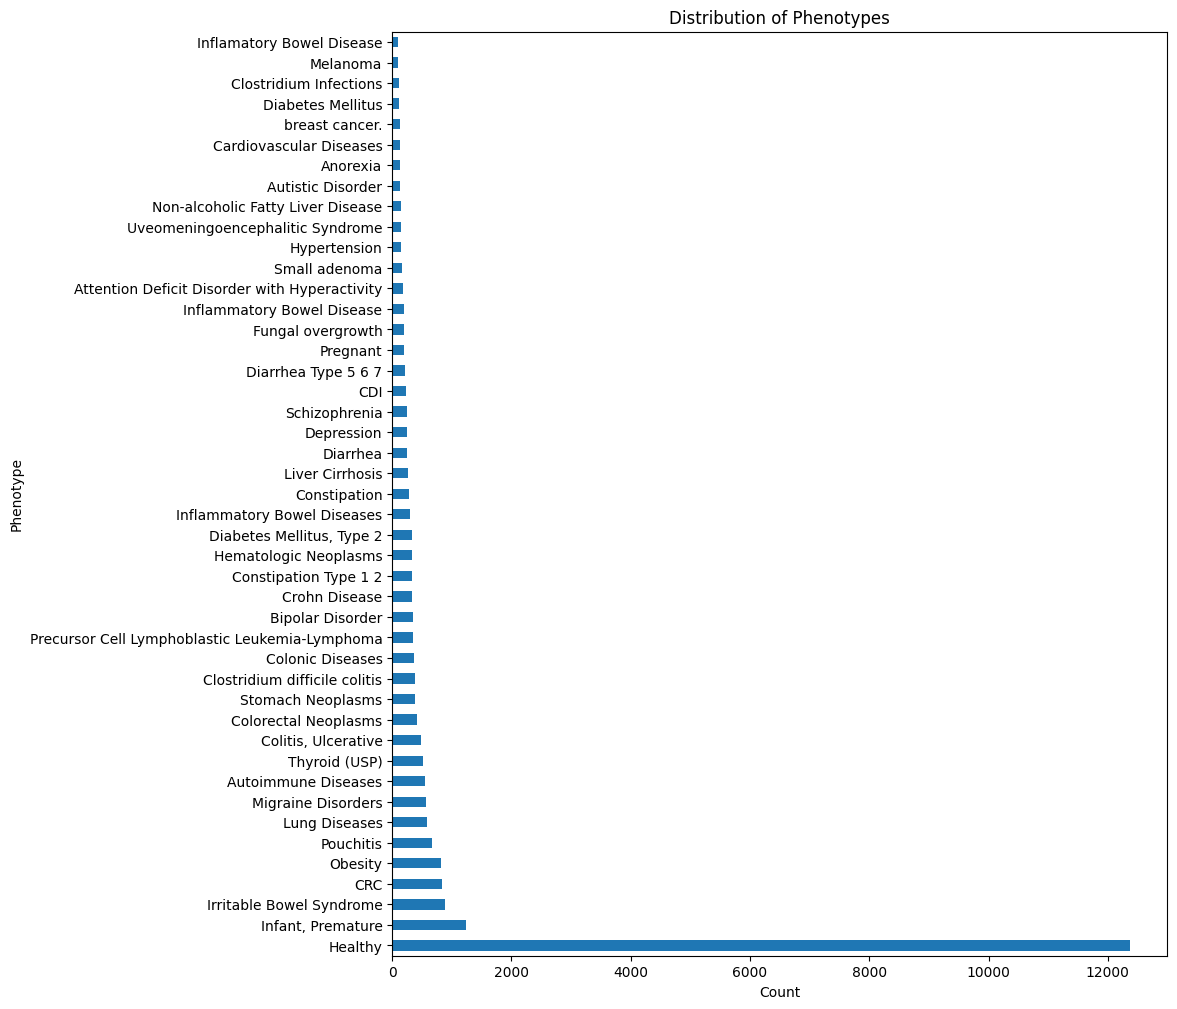

In [421]:
#plot remaining categories

plt.figure(figsize=(10, 12))

metadata_df['phenotype'].value_counts().plot(kind='barh')

plt.xlabel('Count')
plt.ylabel('Phenotype')
plt.title('Distribution of Phenotypes')

plt.show()

### PCA of healthy samples

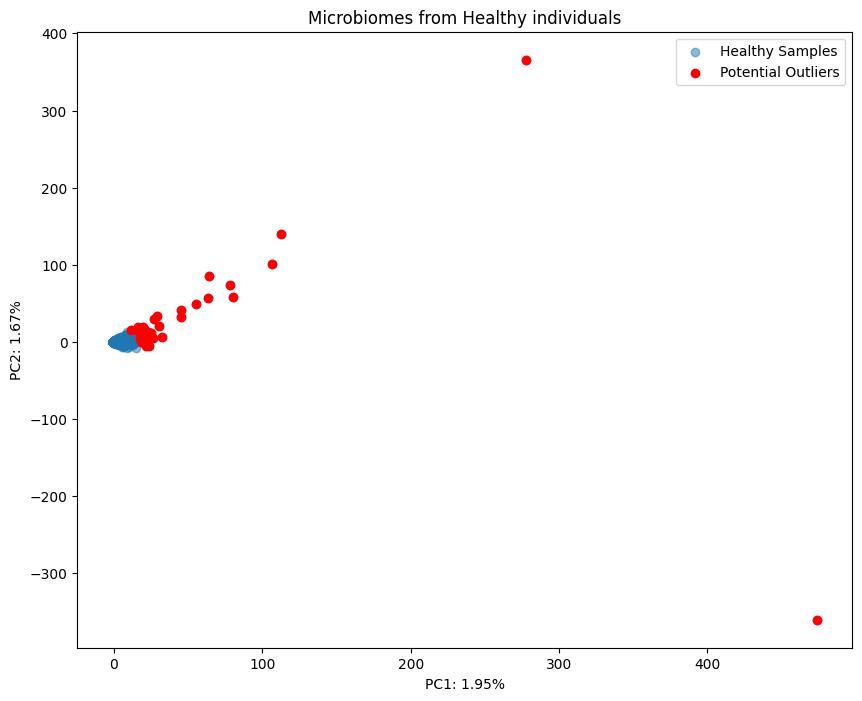

In [422]:
# Convert column names to strings
pivoted_df_Healthy.columns = pivoted_df_Healthy.columns.astype(str)

# Standardize data
scaler = StandardScaler()
pivoted_df_Healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivoted_df_Healthy_standardized)

# Create a DataFrame with standardized PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Calculate Z-scores for each PC
z_scores = zscore(pca_df)

# Set a threshold for Z-scores to identify outliers (e.g., threshold = 3)
outlier_threshold = 3
outliers = (z_scores > outlier_threshold).any(axis=1)

# Identify outlier samples
outlier_samples = pca_df[outliers]

# Scatter plot of standardized PCA results
plt.figure(figsize=(10, 8))

# Show the percentage of variation explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
plt.title(f'Microbiomes from Healthy individuals')
plt.xlabel(f'PC1: {explained_var_ratio[0]*100:.2f}%')
plt.ylabel(f'PC2: {explained_var_ratio[1]*100:.2f}%')

# Scatter plot of standardized PCA results
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, label='Healthy Samples')
plt.scatter(outlier_samples['PC1'], outlier_samples['PC2'], color='red', label='Potential Outliers')

plt.legend()
plt.show()


In [427]:
outliers.index = pivoted_df_Healthy.index

In [429]:
outliers = pd.DataFrame(outliers)
outliers_ = outliers[outliers[0]]
outliers_ = pd.DataFrame(outliers_.index)

In [388]:
#remove outliers from pivoted_df_Healthy and healthy metadata
pivoted_df_Healthy = pivoted_df_Healthy[~pivoted_df_Healthy.index.isin(outliers_["loaded_uid"])]

In [443]:
pivoted_df_Healthy

ncbi_taxon_id,Azorhizobium,Cellvibrio,Dictyoglomus,Methylophilus,Pelobacter,Phenylobacterium,Shewanella,Myxococcus,Stigmatella,Cystobacter,...,2211641,2212691,2212731,2282523,2282740,2282741,2282742,2304691,2304692,2529408
loaded_uid,,,,,,,,,,,,,,,,,,,,,
6791,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8905,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8906,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8907,0.0,0.0,0.0,0.0,0.0,0.0,0.005849,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6792,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6008,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6060,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7342,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [439]:
healthy_metadata[~healthy_metadata["uid"].isin(outliers_["loaded_uid"])]

,checking,project_id,our_project_id,sample_name,original_sample_description,curated_sample_description,run_id,sample_id,second_sample_id,experiment_type,...,Antibiotics.Dose,Days.Without.Antibiotics.Use,uid,accession_id,data_type,tool_used,results_version,last_updated,QCStatus,QCMessage
326,1,PRJDB4360,NaN,Japanese327,Healthy Japanese gut microbiota,NaN,DRR049319,NaN,SAMD00043169,Amplicon,...,NaN,NaN,6791,DRR049319,amplicon,Mapseq,1.0,2019-01-01 00:00:00,1,NaN
726,1,PRJDB4998,NaN,YB_51,Microbiota of the fecal sample from subject 51,NaN,DRR067938,NaN,SAMD00058143,Amplicon,...,NaN,NaN,8905,DRR067938,amplicon,Mapseq,1.0,2019-01-01 00:00:00,1,NaN
914,1,PRJDB4998,NaN,YB_239,Microbiota of the fecal sample from subject 239,NaN,DRR068126,NaN,SAMD00058331,Amplicon,...,NaN,NaN,8906,DRR068126,amplicon,Mapseq,1.0,2019-01-01 00:00:00,1,NaN
916,1,PRJDB4998,NaN,YB_241,Microbiota of the fecal sample from subject 241,NaN,DRR068128,NaN,SAMD00058333,Amplicon,...,NaN,NaN,8907,DRR068128,amplicon,Mapseq,1.0,2019-01-01 00:00:00,1,NaN
1261,1,PRJDB4360,NaN,Japanese401,Healthy Japanese gut microbiota,NaN,DRR092034,NaN,SAMD00079898,Amplicon,...,NaN,NaN,6792,DRR092034,amplicon,Mapseq,1.0,2019-01-01 00:00:00,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53303,1,PRJNA215106,NaN,F34_CY,Functional metagenomic selections were perform...,NaN,SRR961853,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6008,SRR961853,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53304,1,PRJNA215106,NaN,F34_PE,Functional metagenomic selections were perform...,NaN,SRR961854,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6060,SRR961854,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53305,1,PRJNA215106,NaN,F34_TE,Functional metagenomic selections were perform...,NaN,SRR961855,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,7342,SRR961855,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN
53306,1,PRJNA215106,NaN,F34_TR,Functional metagenomic selections were perform...,NaN,SRR961856,SAMN02317178,SAMN02317178,Metagenomics,...,NaN,NaN,6054,SRR961856,metagenomics,metaphlan ver2.0,0.1,2019-01-01 00:00:00,1,NaN


In [411]:
healthy_metadata[~outliers_["loaded_uid"]]

KeyError: "None of [Int64Index([-36383, -36446, -25147, -25148, -25149, -25150, -25153, -25154,\n            -25155, -17570, -17571, -17572,  -9836,  -9839,  -9846,  -9851,\n             -9861,  -9877,  -9888,  -9897, -10713, -23938, -23942, -23945,\n            -23991, -23993, -24000, -24009, -22837, -42852, -28049, -28242,\n            -48102, -47677, -47680, -48173, -48175, -48177, -48185],\n           dtype='int64')] are in the [columns]"

326      6791
726      8905
914      8906
916      8907
1261     6792
         ... 
53303    6008
53304    6060
53305    7342
53306    6054
53307    5989
Name: uid, Length: 12376, dtype: int64

In [333]:
healthy_metadata.loc[outliers, "uid"]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [332]:
outlier_uids = healthy_metadata.loc[outliers, "uid"]

# Remove rows where "uid" matches with the outliers
filtered_healthy_metadata = healthy_metadata[~healthy_metadata["uid"].isin(outlier_uids)]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

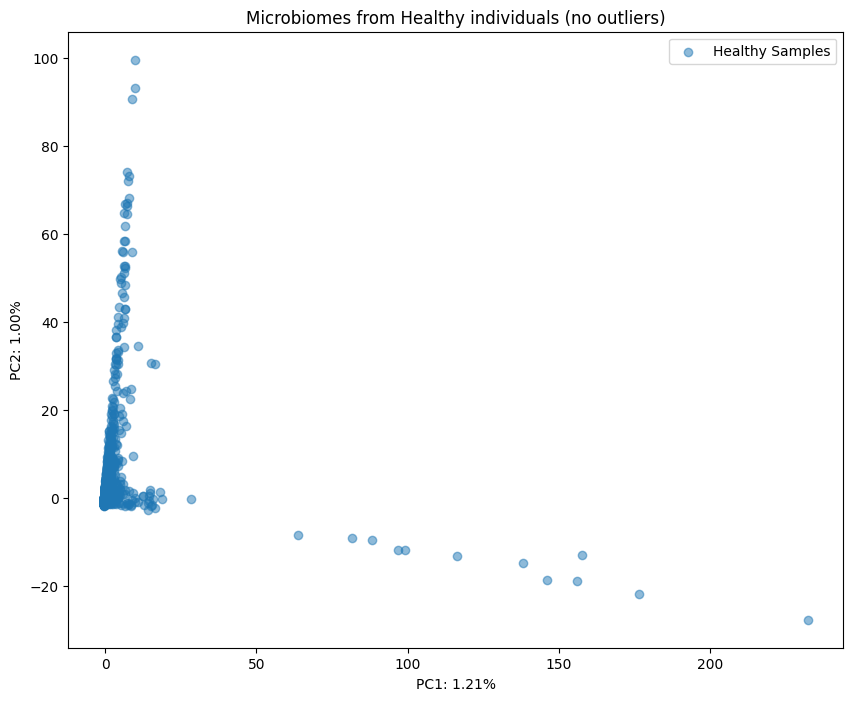

In [260]:
# Convert column names to strings
pivoted_df_Healthy.columns = pivoted_df_Healthy.columns.astype(str)

# Standardize data
scaler = StandardScaler()
pivoted_df_Healthy_standardized = scaler.fit_transform(pivoted_df_Healthy)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(pivoted_df_Healthy_standardized)

# Create a DataFrame with standardized PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Scatter plot of standardized PCA results
plt.figure(figsize=(10, 8))

# Show the percentage of variation explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
plt.title(f'Microbiomes from Healthy individuals (no outliers)')
plt.xlabel(f'PC1: {explained_var_ratio[0]*100:.2f}%')
plt.ylabel(f'PC2: {explained_var_ratio[1]*100:.2f}%')

# Scatter plot of standardized PCA results
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, label='Healthy Samples')

plt.legend()
plt.show()


### PCA  

In [261]:
# phenotypes

# Assuming metadata_df contains the "phenotype" and "uid" columns
phenotype_labels = metadata_df[["phenotype", "uid"]]

# Separate labels into "Healthy" and "Non-Healthy"
healthy_labels = phenotype_labels[phenotype_labels["phenotype"] == "Healthy"]
non_healthy_labels = phenotype_labels[phenotype_labels["phenotype"] != "Healthy"]

In [269]:
non_healthy_labels

,phenotype,uid
1576,Bipolar Disorder,38424
1577,Depression,38424
1578,Fungal overgrowth,38424
1579,Lung Diseases,38424
1580,Schizophrenia,38424
...,...,...
52984,Crohn Disease,51129
52993,Crohn Disease,51130
52999,Crohn Disease,51131
53012,Crohn Disease,51132


In [270]:
pivoted_df_non_healthy

ncbi_taxon_id,Azorhizobium,Cellvibrio,Dictyoglomus,Methylophilus,Pelobacter,Phenylobacterium,Shewanella,Myxococcus,Stigmatella,Cystobacter,...,2211641,2212691,2212731,2282523,2282740,2282741,2282742,2304691,2304692,2529408
loaded_uid,,,,,,,,,,,,,,,,,,,,,
38424,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
38424,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
38424,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
38424,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
38424,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51129,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.012595,0.0
51130,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011003,0.055018,0.0
51131,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [266]:
import random

# Set a seed for reproducibility
random.seed(42)

# Scatter plot of standardized PCA results
plt.figure(figsize=(25, 20))

# Generate len(unique_phenotypes) random colors
colors = [tuple(random.uniform(0, 1) for _ in range(3)) for _ in range(len(unique_phenotypes))]

# Loop through unique phenotypes for coloring and legend
for phenotype, color in zip(unique_phenotypes, colors):
    subset_df = pca_df[pca_df['Label'] == phenotype]
    plt.scatter(subset_df['PC1'], subset_df['PC2'], label=phenotype, c=[color], alpha=0.6)

plt.title('PCA of pivoted_df_filtered (Standardized)')
plt.xlabel('Standardized Principal Component 1')
plt.ylabel('Standardized Principal Component 2')

# Show the percentage of variation explained by each PC
explained_var_ratio = pca.explained_variance_ratio_
plt.text(-2, 2, f'PC1: {explained_var_ratio[0]*100:.2f}%\nPC2: {explained_var_ratio[1]*100:.2f}%', fontsize=12)

# Add legend
plt.legend()

plt.show()


KeyError: 'Label'

<Figure size 2500x2000 with 0 Axes>